In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cf_helper_2 as cf_helper
import matplotlib.pyplot as plt
import importlib
%matplotlib notebook
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
importlib.reload(cf_helper)

<module 'cf_helper_2' from '/Users/julianganzabal/facultad/lab-ml/Sistemas-de-Recomendacion/cf_helper_2.py'>

In [2]:
#df = pd.read_csv('movielens/ml-latest-small/ratings.csv')[['userId','movieId','rating']]
header = ['userId', 'movieId', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)

In [3]:
def get_user_item_matrix(dataframe, userIndexTag, itemIndexTag,ratingTag, test_size_ratio, base_1 = False):
    first = 0
    if base_1:
        first = 1
    n_users = dataframe[userIndexTag].unique().shape[0]
    n_items = dataframe[itemIndexTag].unique().shape[0]
    train_data, test_data = train_test_split(dataframe, test_size=test_size_ratio)

    R = np.zeros((n_users, n_items))
    T = np.zeros((n_users, n_items))
    print(R.shape)

    for index, line in train_data.iterrows():
        R[line[userIndexTag] - first, line[itemIndexTag] - first] = line[ratingTag]


    for index, line in test_data.iterrows():
        T[line[userIndexTag] - first, line[itemIndexTag] - first] = line[ratingTag]
    print(T.shape)
    return R,T
R_train, R_test = get_user_item_matrix(df, 'userId','movieId','rating',0.25, base_1 = True)

(943, 1682)
(943, 1682)


In [4]:
R_rated_indexes_train = R_train.nonzero()
R_rated_indexes_test = R_test.nonzero()

In [5]:
I_train = R_train.copy()
T_test = R_test.copy()
I_train[I_train==0] = 0
I_train[I_train!=0] = 1
T_test[T_test==0] = 0
T_test[T_test!=0] = 1

In [6]:
def get_estimated_R(SM, R_tr, R_ts, R_rated_indexes_tr, R_rated_indexes_ts, k = -1, means = 0,divide_by_weights_sum = True, count_diag = False, relevant_rate = 1, perc_points = 100):
    if k==-1:
        R_est = cf_helper.predictions(R_tr, SM, divide_by_weights_sum= divide_by_weights_sum, count_diag = count_diag, means = means)
    else:
        R_est = cf_helper.predictions_K_neighbours(R_tr, SM, k=k, means = means, divide_by_weights_sum= divide_by_weights_sum, count_diag = count_diag)
    rmse_tr= cf_helper.rmse(R_tr,R_est)
    rmse_ts = cf_helper.rmse(R_ts, R_est)
    perc = cf_helper.get_percentiles(R_ts, R_est, like = relevant_rate, points = perc_points, number_of_random_items = 500)
    print(rmse_tr,rmse_ts)
    return R_est, perc, rmse_ts

In [7]:
perc_points = 100
relevant_rate = 5

In [8]:
SM_pearson2, user_means2 = cf_helper.getPearsonSimilarityMatrix_non_zeros(R_train)

In [9]:
SM_jaccard, _ = cf_helper.calcultaSimilarityMatrix(R_train, dist_type ='jaccard_with_negatives')
SM_pearson, user_means = cf_helper.calcultaSimilarityMatrix(R_train, dist_type ='pearson')
SM_cosine, _ = cf_helper.calcultaSimilarityMatrix(R_train, dist_type ='cosine')

In [10]:
R_est_pearson2, perc_pearson2, rmse_pearson2 = get_estimated_R(SM_pearson2, R_train, R_test, R_rated_indexes_train, R_rated_indexes_test, 
                                                               means = user_means2, perc_points = perc_points, relevant_rate = relevant_rate)

1.91495883673 1.95547461573


In [11]:
R_est_pearson, perc_pearson, rmse_pearson = get_estimated_R(SM_pearson, R_train, R_test, R_rated_indexes_train, R_rated_indexes_test, means = user_means, perc_points = perc_points, relevant_rate = relevant_rate)

2.90082707037 2.94041925163


In [12]:
R_est_cosine, perc_cosine, rmse_cosine = get_estimated_R(SM_cosine, R_train, R_test, R_rated_indexes_train, R_rated_indexes_test, perc_points = perc_points, relevant_rate = relevant_rate, means = 0)

3.00587368978 3.03079327328


In [13]:
R_est_jaccard, perc_jaccard, rmse_jaccard = get_estimated_R(SM_jaccard,R_train, R_test, R_rated_indexes_train, R_rated_indexes_test, perc_points = perc_points, relevant_rate = relevant_rate)

2.96441246543 2.99331452777


In [14]:
mu_train = R_train[R_rated_indexes_train].mean()
percentiles_train_media = cf_helper.get_percentiles(R_test, mu_train*np.ones(R_train.shape), like = 5)

In [15]:
def get_biased_data(R_tr, bias):
    R_tr_b = R_tr.copy()
    R_tr_b[R_tr==0] = bias
    return R_tr_b

In [16]:
R_train_biased = get_biased_data(R_train, mu_train)
SM_biased, user_means_biased = cf_helper.calcultaSimilarityMatrix(R_train_biased, dist_type ='pearson')
R_est_biased, perc_biased, rmse_biased = get_estimated_R(SM_biased, R_train_biased, R_test, R_rated_indexes_train, R_rated_indexes_test, means=user_means_biased, relevant_rate = relevant_rate)

0.228962562889 1.07588903493


/Users/julianganzabal/anaconda3/envs/mllab/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


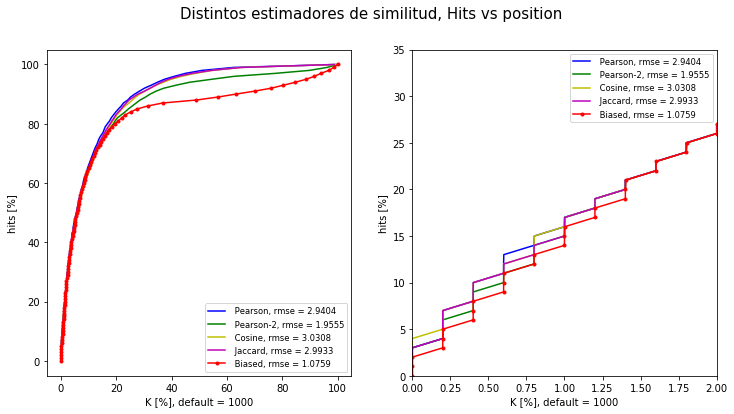

In [17]:
%matplotlib inline
perc_basis_vect = [perc_pearson, perc_pearson2,perc_cosine, perc_jaccard, perc_biased]
rmse_basis_vect = [rmse_pearson, rmse_pearson2,rmse_cosine, rmse_jaccard, rmse_biased]
names_basis_vect = ['Pearson','Pearson-2','Cosine','Jaccard', 'Biased']
cf_helper.plot_percentiles(names_basis_vect, rmse_basis_vect, perc_basis_vect,
                 parameter_name ='', title= 'Distintos estimadores de similitud, Hits vs position',
                 featured_idx = 4, featured_text = 'Biased')


 Ejemplo: si k=2 y hits=30 
 El 30% de los items relevantes se encuentran dentro de los primeros 20 items (1000 * k/100)


/Users/julianganzabal/anaconda3/envs/mllab/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


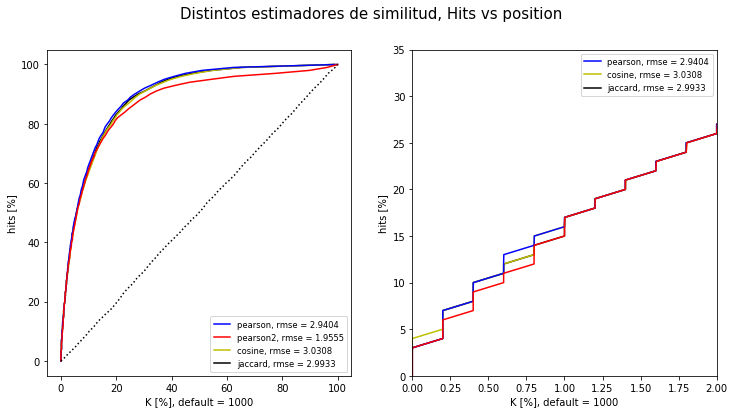

In [18]:
f, ([ax1, ax2]) = plt.subplots(1,2, sharex=False, sharey=False, figsize=(12, 6)) #, figsize=(10, 10)
plt_jaccard, = ax1.plot(*perc_jaccard, color = 'k', label = 'jaccard, rmse = %.4f'%rmse_jaccard)
plt_cosine, = ax1.plot(*perc_cosine, color = 'y', label = 'cosine, rmse = %.4f'%rmse_cosine)
plt_pearson, = ax1.plot(*perc_pearson, color = 'b', label = 'pearson, rmse = %.4f'%rmse_pearson)
plt_pearson2, = ax1.plot(*perc_pearson2, color = 'R', label = 'pearson2, rmse = %.4f'%rmse_pearson2)

ax1.plot(*percentiles_train_media, linestyle = ":", color = 'k')

ax1.legend(handles=[plt_pearson, plt_pearson2, plt_cosine, plt_jaccard], loc = 'best', prop = fontP)
ax1.set_xlabel('K [%], default = 1000')
ax1.set_ylabel('hits [%]')

ax2.plot(*perc_jaccard,  color = 'k')
ax2.plot(*perc_cosine,  color = 'y')
ax2.plot(*perc_pearson, color = 'b')
ax2.plot(*perc_pearson2, color = 'r')

ax2.legend(handles=[plt_pearson, plt_cosine, plt_jaccard], loc = 'best', prop = fontP)
ax2.set_xlabel('K [%], default = 1000')
ax2.set_ylabel('hits [%]')
ax2.set_ylim([0,35])
ax2.set_xlim([0,2])

print('\n Ejemplo: si k=2 y hits=30 \n El 30% de los items relevantes se encuentran dentro de los primeros 20 items (1000 * k/100)')
f.suptitle('Distintos estimadores de similitud, Hits vs position', fontsize = 15)
f.show()

# Matrix Factorization

In [19]:
from cf_helper_2 import Matrix_Factorization_baselines_SGD

In [33]:
mu = R_train[R_train.nonzero() ].mean()

In [39]:
P, Q, bu, bi, train_rmse_vector, test_rmse_vector, train_accuracy_vector, train_accuracy_vector, gamma, lmbda \
= Matrix_Factorization_baselines_SGD(R_train , R_test, R_rated_indexes_train, R_rated_indexes_test, mu, k=20 ,sigma = 0.002,
                           gamma= 0.01, lmbda = 0, alpha = 0, 
                           n_epochs = 100, error_calc_frec = 1,
                           accuracy_thres = 0, like = 1, dislike = -1)

epoch = -1 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (1.125064, 1.127469)
epoch = 0 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.971465, 0.987257)
epoch = 1 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.946400, 0.968579)
epoch = 2 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.935084, 0.960725)
epoch = 3 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.928574, 0.956469)
epoch = 4 accuracy (train, test): (6.1093, 6.1080), rmse (train, test): (0.924419, 0.953945)
epoch = 5 accuracy (train, test): (6.1093, 6.1080), rmse (train, test): (0.921590, 0.952371)
epoch = 6 accuracy (train, test): (6.1093, 6.1080), rmse (train, test): (0.919571, 0.951355)
epoch = 7 accuracy (train, test): (6.1080, 6.1080), rmse (train, test): (0.918073, 0.950681)
epoch = 8 accuracy (train, test): (6.1080, 6.1080), rmse (train, test): (0.916922, 0.950226)
epoch = 9 accuracy (train, test): (6.1080, 6.1040), rmse (train, test

epoch = 86 accuracy (train, test): (6.1053, 5.8920), rmse (train, test): (0.490835, 1.128465)
epoch = 87 accuracy (train, test): (6.1067, 5.8880), rmse (train, test): (0.489872, 1.130461)
epoch = 88 accuracy (train, test): (6.1067, 5.8840), rmse (train, test): (0.488936, 1.132432)
epoch = 89 accuracy (train, test): (6.1067, 5.8840), rmse (train, test): (0.488027, 1.134377)
epoch = 90 accuracy (train, test): (6.1067, 5.8800), rmse (train, test): (0.487142, 1.136297)
epoch = 91 accuracy (train, test): (6.1067, 5.8800), rmse (train, test): (0.486282, 1.138193)
epoch = 92 accuracy (train, test): (6.1067, 5.8800), rmse (train, test): (0.485444, 1.140065)
epoch = 93 accuracy (train, test): (6.1067, 5.8800), rmse (train, test): (0.484628, 1.141915)
epoch = 94 accuracy (train, test): (6.1067, 5.8760), rmse (train, test): (0.483834, 1.143743)
epoch = 95 accuracy (train, test): (6.1067, 5.8800), rmse (train, test): (0.483059, 1.145549)
epoch = 96 accuracy (train, test): (6.1067, 5.8800), rmse (t

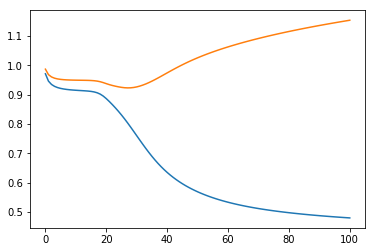

In [40]:
plt.plot(train_rmse_vector)
plt.plot(test_rmse_vector)
plt.show()

# SVD

In [55]:
from cf_helper_2 import SVD, rmse, getBaselineEstimates

In [121]:
# k=800, 20
SVD_Predictions = SVD(R_train, k=20)

In [122]:
print('Training:',rmse(R_train, SVD_Predictions))
print('Testing:',rmse(R_test, SVD_Predictions))

Training: 2.38593300816
Testing: 2.71598855321


In [84]:
mu = R_train[R_train.nonzero()].mean()

In [61]:
R_train_norm = (R_train - mu)*(R_train>0)

In [86]:
SVD_Predictions_norm = SVD(R_train_norm, k=20) + mu

In [87]:
print('Training:',rmse(R_train, SVD_Predictions_norm))
print('Testing:',rmse(R_test, SVD_Predictions_norm))

Training: 0.910286953239
Testing: 1.04819270122


In [88]:
bii, bui = getBaselineEstimates(R_train, mu, lambda1 = 0, lambda2 = 0, items_first = True, not_rated = 0)
baseline = mu + bui + bii.T

In [89]:
R_train_baseline = (R_train - baseline.T)*(R_train>0)

In [91]:
SVD_Predictions_baseline = SVD(R_train_baseline, k=20) + baseline.T

In [110]:
# k=500, k= 100, K=10, k = 5, k=18
SVD_Predictions_baseline_10 = SVD(R_train_baseline, k=18) + baseline.T
print('Training:',rmse(R_train, SVD_Predictions_baseline_10))
print('Testing:',rmse(R_test, SVD_Predictions_baseline_10))

Training: 0.792122927085
Testing: 0.93954642185
